# Inertial Data Classification using SVM

This notebook demonstrates an end-to-end pipeline for classifying inertial sensor data.
It covers:
1. Data exploration
2. Feature extraction
3. Feature filtering
4. Model training (SVM)
5. Evaluation and insights

In [3]:
# Imports
import sys
from pathlib import Path

# Add project root to sys.path
ROOT = Path.cwd().parent  # if notebook is in /notebooks
sys.path.append(str(ROOT / "src"))

# Now you can import your scripts
from extract_files import extract
from filter_features import filter_features
from SVM_LOO import run_svm_classification
from SVM_classify import predict_new_samples
import pandas as pd
import glob
import tsfel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
files = glob.glob(str(ROOT / "raw_data/train" / "*.txt"))
print(f"{len(files)} files found.")
sample_file = files[0]

# Example preview
with open(sample_file, 'r') as f:
    for _ in range(10):
        print(f.readline().strip())


34 files found.
t: 100; Acc:   0.64,  -0.71,  -0.16
Gyro:  -0.92,  -3.66,   1.71
t: 100; Acc:   0.64,  -0.71,  -0.16
Gyro:  -1.10,  -3.60,   1.46
t: 100; Acc:   0.64,  -0.71,  -0.16
Gyro:  -1.16,  -4.88,   1.22
t: 100; Acc:   0.65,  -0.70,  -0.16
Gyro:  -1.77,  -4.58,   1.28
t: 100; Acc:   0.64,  -0.72,  -0.13
Gyro:  -3.30,  -6.59,   4.15


In [4]:
# Run extraction
extract(str(ROOT / "raw_data" / "train"), csv_path = False)

# Load the combined features CSV

features = pd.read_csv(ROOT / "processed_data" / "combined_features.csv", sep = ';')
features.head(10) #the first 10 rows, as an example

,Accel_X_Absolute energy,Accel_X_Area under the curve,Accel_X_Autocorrelation,Accel_X_Average power,Accel_X_Centroid,Accel_X_ECDF Percentile Count_0,Accel_X_ECDF Percentile Count_1,Accel_X_ECDF Percentile_0,Accel_X_ECDF Percentile_1,Accel_X_ECDF_0,...,Gyro_Z_Root mean square,Gyro_Z_Signal distance,Gyro_Z_Skewness,Gyro_Z_Slope,Gyro_Z_Standard deviation,Gyro_Z_Sum absolute diff,Gyro_Z_Variance,Gyro_Z_Zero crossing rate,File,Class
0,14.4134,1.5710,1.0,6.266696,1.156401,4.0,19.0,0.50,0.76,0.041667,...,75.323589,953.958883,0.775484,0.484317,75.271761,949.40,5665.837982,4.0,biqueira_12.txt,biqueira
1,22.0745,1.8735,1.0,9.197708,1.497041,5.0,20.0,0.58,0.85,0.040000,...,72.666583,853.299852,1.637608,0.262654,72.648290,850.58,5277.774020,5.0,biqueira_13.txt,biqueira
2,25.9314,1.8325,1.0,12.348286,1.068044,4.0,17.0,0.59,0.81,0.045455,...,138.663913,1732.551496,2.966536,-0.009023,137.741628,1731.69,18972.756023,6.0,biqueira_14.txt,biqueira
3,14.8484,1.5890,1.0,5.939360,1.272045,5.0,20.0,0.48,0.63,0.038462,...,82.942664,1079.950106,1.086036,1.005897,82.925874,1072.74,6876.700503,6.0,biqueira_15.txt,biqueira
4,15.1599,1.6935,1.0,6.316625,1.174584,5.0,20.0,0.60,0.83,0.040000,...,96.124808,1335.521745,0.930874,0.207446,96.124221,1333.69,9239.865792,8.0,biqueira_16.txt,biqueira
5,22.4001,1.6115,1.0,11.200050,1.181970,4.0,16.0,0.49,0.78,0.047619,...,116.475620,1393.859425,1.533088,0.895636,116.086461,1392.26,13476.066537,6.0,biqueira_17.txt,biqueira
6,18.0726,1.5535,1.0,8.606000,1.269709,4.0,17.0,0.44,0.66,0.045455,...,141.740903,1735.441787,2.283615,2.112592,140.903610,1733.17,19853.827241,9.0,biqueira_18.txt,biqueira
7,15.0042,1.5605,1.0,6.820091,1.034495,4.0,18.0,0.50,0.70,0.043478,...,94.414914,1449.008702,1.138141,0.998241,94.230606,1447.39,8879.407040,8.0,biqueira_19.txt,biqueira
8,39.6218,1.8535,1.0,20.853579,1.296939,4.0,16.0,0.63,0.98,0.050000,...,98.771863,1108.921049,1.008680,0.088165,98.741991,1107.48,9749.980819,8.0,biqueira_20.txt,biqueira
9,31.4190,2.2820,1.0,10.473000,1.577184,6.0,24.0,0.37,0.78,0.032258,...,135.704364,2312.689647,1.098983,0.263427,135.666133,2309.63,18405.299647,11.0,biqueira_21.txt,biqueira


In [5]:
# Filter features
filter_features(str(ROOT / "raw_data/train"))

# Load filtered features
filtered = pd.read_csv(ROOT / "processed_data" / "filtered_features.csv", sep = ';')
print(f"Filtered dataset shape: {filtered.shape}")
filtered.head(10)

Filtered file saved to: filtered_features.csv
Filtered dataset shape: (34, 7)


,File,Gyro_Z_Area under the curve,Gyro_X_Slope,Gyro_X_Sum absolute diff,Gyro_X_Signal distance,Accel_Z_Mean,Class
0,biqueira_12.txt,103.3960,-0.087274,815.25,819.516508,-0.168750,biqueira
1,biqueira_13.txt,104.8770,-1.388931,865.92,868.726422,-0.110000,biqueira
2,biqueira_14.txt,137.8595,-0.937499,1340.42,1343.587995,-0.103636,biqueira
3,biqueira_15.txt,107.5000,-0.022848,631.29,636.571654,-0.179231,biqueira
4,biqueira_16.txt,132.6925,-0.368423,819.66,822.547223,-0.157200,biqueira
5,biqueira_17.txt,133.5480,0.141883,745.59,747.452576,-0.174762,biqueira
6,biqueira_18.txt,138.2385,-0.934348,733.25,736.101350,-0.137727,biqueira
7,biqueira_19.txt,96.0325,-0.244407,749.71,752.747188,-0.167826,biqueira
8,biqueira_20.txt,118.5330,-1.500714,797.50,798.795169,-0.099000,biqueira
9,biqueira_21.txt,172.9535,-0.895157,1627.89,1630.417394,-0.081613,biqueira


## Choice of MLA

Orange 3 was used to choose the best algorithm for the task, the program ended up giving Support Vector Machine (SVM).

## Feature Relevance

The features were narrowed down to the 5 most relevant, to avoid overfitting, the process was also done on Orange 3, and the features are:

- Gyro_Z_Area under the curve
- Gyro_X_Slope
- Gyro_X_Sum absolute diff
- Gyro_X_Signal distance
- Accel_Z_Mean

4 of the 5 most discriminative features are related to the angular momentum of the movements, wich highlights the importance of this component.


Model Accuracy: 85.29%

Classification Report:
                 precision    recall  f1-score   support

       biqueira       0.80      0.80      0.80        10
parte de dentro       0.88      0.78      0.82         9
       rejeicao       1.00      1.00      1.00         7
        trivela       0.78      0.88      0.82         8

       accuracy                           0.85        34
      macro avg       0.86      0.86      0.86        34
   weighted avg       0.86      0.85      0.85        34


Confusion Matrix:
[[8 1 0 1]
 [1 7 0 1]
 [0 0 7 0]
 [1 0 0 7]]


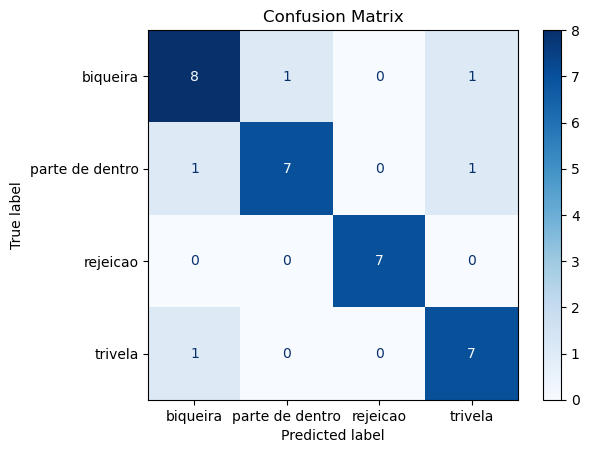

Trained model saved successfully at: C:\Users\35193\PycharmProjects\Movement Classifier\Movement-classifier\processed_data\svm_model.pkl


In [8]:
results = run_svm_classification(str(ROOT / "processed_data" / "filtered_features.csv"))

In [4]:
predict_new_samples(str(ROOT / "raw_data" / "test"), str(ROOT / "processed_data" / "svm_model.pkl") )

Filtered file saved to: filtered_features.csv

Predictions for new samples:
biqueira_11.txt: Predicted class = rejeicao
parte de dentro_11.txt: Predicted class = rejeicao
rejeicao_1.txt: Predicted class = rejeicao
trivela_11.txt: Predicted class = rejeicao


C:\Users\35193\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


## Comparison with another model (Random Forest)

In order to prove that SVM is the best model found for this task, random forest is also employed.
Firstly the 5 most discriminative features are going to be selected.

In [ ]:
X = features.drop(["Class", "File"], axis=1)
y = features["Class"]

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(5).plot(kind="bar", figsize=(12,6))
relevant_features = importances.index.tolist()
plt.title("Feature Importance (Random Forest)")
plt.show()



For random forest, 3 of the 5 most important features are related to the linear acceleration. This might indicate that this algorithm is able to capture patterns that SVM can not.

In [ ]:
X = X[relevant_features]

# Random Forest
rf_v2 = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf_v2, X, y, cv=5)
print(f"Random Forest 5-fold accuracy: {np.mean(rf_scores):.3f}")
